In [48]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from pathlib import Path
import regex as re
import nltk
from datetime import date
import twint
import nest_asyncio
import tensorflow as tf
nest_asyncio.apply()
nltk.download('stopwords')

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
# Set the random seed for reproducibility
from numpy.random import seed
seed(1)

from tensorflow import random
random.set_seed(2)

In [50]:
# Data crawling using Twint
import twint
import nest_asyncio
nest_asyncio.apply()

import datetime

# Fetch data in a example data frame: 2020-04-14 00:00:00 to 2020-04-14 00:30:00

start_time='2020-01-01 00:00:00'

c = twint.Config()
c.Search = "microsoft"
c.Lang="en"
c.Since= start_time
c.Limit = 5000
c.Pandas = True
c.Store_csv = True
c.Retries_count = 20
c.Hide_output = True
c.Custom["tweet"] = ["id", "date", "time", "tweet", "retweets_count", "likes_count"]
c.Resume = "./test.session"
c.Output = "./test.csv"
twint.run.Search(c)

In [51]:
file_path = 'test.csv'
df = pd.read_csv(file_path, parse_dates=[['date','time']], infer_datetime_format=True)
df.head()

,date_time,id,tweet,retweets_count,likes_count
0,2021-01-19 20:55:16,1351709850380587008,Microsoft partners with GM subsidiary Cruise o...,0,0
1,2021-01-19 20:55:03,1351709796534255617,Xbox support is so fucking useless thanks for ...,0,0
2,2021-01-19 20:54:55,1351709762405216258,Thank God I remembered Xbox has Microsoft Edge...,0,1
3,2021-01-19 20:54:55,1351709760047878144,Mana nak dapat Microsoft Access woii😫😫,0,0
4,2021-01-19 20:54:52,1351709749641965571,Anybody else wonder why noone has started a ma...,0,0


In [52]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer 

analyzer = SentimentIntensityAnalyzer()
text_sent = {'Compound':[],
                 'Negative':[],
                 'Neutral':[],
                 'Positive':[]}
# Get sentiment from articles
for index, row in df.iterrows():
    try:
        text_sentiment = analyzer.polarity_scores(row["tweet"])
        text_sent["Compound"].append(text_sentiment["compound"])
        text_sent["Negative"].append(text_sentiment["neg"])
        text_sent["Neutral"].append(text_sentiment["neu"])
        text_sent["Positive"].append(text_sentiment["pos"])
        #text_sent["text_sent"].append(get_sentiment(text_sentiment["compound"]))
    except AttributeError:
        pass
# Add the newly created scores to the previously created bitcoin dataframe
text_sent_df = pd.DataFrame(text_sent)
test_sentiment = text_sent_df.join(df)
test_sentiment.head()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\julia\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Compound,Negative,Neutral,Positive,date_time,id,tweet,retweets_count,likes_count
0,0.0000,0.000,1.000,0.000,2021-01-19 20:55:16,1351709850380587008,Microsoft partners with GM subsidiary Cruise o...,0,0
1,0.8612,0.108,0.574,0.319,2021-01-19 20:55:03,1351709796534255617,Xbox support is so fucking useless thanks for ...,0,0
2,0.7269,0.000,0.738,0.262,2021-01-19 20:54:55,1351709762405216258,Thank God I remembered Xbox has Microsoft Edge...,0,1
3,0.0000,0.000,1.000,0.000,2021-01-19 20:54:55,1351709760047878144,Mana nak dapat Microsoft Access woii😫😫,0,0
4,-0.4753,0.072,0.928,0.000,2021-01-19 20:54:52,1351709749641965571,Anybody else wonder why noone has started a ma...,0,0


In [54]:
test_sentiment['Sentiment_Score'] = np.nan
test_sentiment.loc[test_sentiment['Compound'] >= 0.05, 'Sentiment_Score'] = 1
test_sentiment.loc[test_sentiment['Compound'] <= - 0.05, 'Sentiment_Score'] = -1
test_sentiment.loc[(test_sentiment['Compound'] < 0.05) & (test_sentiment['Compound'] > -0.05), 'Sentiment_Score']= 0
test_sentiment.head()

,Compound,Negative,Neutral,Positive,date_time,id,tweet,retweets_count,likes_count,Sentiment_Score
0,0.0000,0.000,1.000,0.000,2021-01-19 20:55:16,1351709850380587008,Microsoft partners with GM subsidiary Cruise o...,0,0,0.0
1,0.8612,0.108,0.574,0.319,2021-01-19 20:55:03,1351709796534255617,Xbox support is so fucking useless thanks for ...,0,0,1.0
2,0.7269,0.000,0.738,0.262,2021-01-19 20:54:55,1351709762405216258,Thank God I remembered Xbox has Microsoft Edge...,0,1,1.0
3,0.0000,0.000,1.000,0.000,2021-01-19 20:54:55,1351709760047878144,Mana nak dapat Microsoft Access woii😫😫,0,0,0.0
4,-0.4753,0.072,0.928,0.000,2021-01-19 20:54:52,1351709749641965571,Anybody else wonder why noone has started a ma...,0,0,-1.0


In [55]:
# Convert [-1, 0, 1] to [negative, neutral, and positive]

# Negative
test_sentiment.loc[test_sentiment['Sentiment_Score'] == -1, 'Sentiment_Score'] = 'Negative'

# Neutral

test_sentiment.loc[test_sentiment['Sentiment_Score'] == 0, 'Sentiment_Score'] = 'Neutral'

# Postive
test_sentiment.loc[test_sentiment['Sentiment_Score'] == 1, 'Sentiment_Score'] = 'Positive'

# View Into DataFrame
test_sentiment.tail()

,Compound,Negative,Neutral,Positive,date_time,id,tweet,retweets_count,likes_count,Sentiment_Score
65755,0.0,0.0,1.0,0.0,2021-01-15 02:53:57,1349988176828395520,MicrosoftやOracleが「ワクチン接種パスポート」アプリの開発を計画中だと発表 -...,0,0,Neutral
65756,0.0,0.0,1.0,0.0,2021-01-15 02:53:57,1349988175947546626,「Microsoft 365」に保存可能なファイルサイズが250GBに ～現行の100GBか...,0,0,Neutral
65757,0.0,0.0,1.0,0.0,2021-01-15 02:53:55,1349988169136017410,いいぞもっとやれ 株主より 新型コロナ: 世界共通「ワクチン接種証明書」 Microsof...,0,6,Neutral
65758,0.0,0.0,1.0,0.0,2021-01-15 02:53:52,1349988154418327552,@Kapel_ao @Faraon_Bioshock @el_tijuana23 @Xbox...,0,0,Neutral
65759,0.0,0.0,1.0,0.0,2021-01-15 02:53:35,1349988083937144832,Microsoftの新OS「Windows 10X」のほぼ最終版がリーク、Chrome OS...,0,0,Neutral


In [56]:
# Clean the Text Function
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')


def clean_text(text):
  text = text.lower() # lowercase text
  text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
  text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
  text = text.replace('x', '')
 # text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
  return text

In [57]:
# Apply the clean text function above
test_sentiment['tweet'] = test_sentiment['tweet'].astype(str)
test_sentiment['tweet'] = test_sentiment['tweet'].apply(clean_text)
test_sentiment['tweet'] = test_sentiment['tweet'].str.replace('\d+', '')
test_sentiment.head()

,Compound,Negative,Neutral,Positive,date_time,id,tweet,retweets_count,likes_count,Sentiment_Score
0,0.0000,0.000,1.000,0.000,2021-01-19 20:55:16,1351709850380587008,microsoft partners with gm subsidiary cruise o...,0,0,Neutral
1,0.8612,0.108,0.574,0.319,2021-01-19 20:55:03,1351709796534255617,bo support is so fucking useless thanks for th...,0,0,Positive
2,0.7269,0.000,0.738,0.262,2021-01-19 20:54:55,1351709762405216258,thank god i remembered bo has microsoft edge a...,0,1,Positive
3,0.0000,0.000,1.000,0.000,2021-01-19 20:54:55,1351709760047878144,mana nak dapat microsoft access woii,0,0,Neutral
4,-0.4753,0.072,0.928,0.000,2021-01-19 20:54:52,1351709749641965571,anybody else wonder why noone has started a ma...,0,0,Negative


In [58]:
test_sentiment.describe()

,Compound,Negative,Neutral,Positive,id,retweets_count,likes_count
count,65760.000000,65760.000000,65760.000000,65760.000000,6.576000e+04,65760.000000,65760.000000
mean,0.114241,0.033300,0.890748,0.075950,1.350837e+18,1.052479,4.834428
std,0.370427,0.077305,0.137825,0.117592,5.586549e+14,18.361381,95.778700
min,-0.982500,0.000000,0.087000,0.000000,1.349988e+18,0.000000,0.000000
25%,0.000000,0.000000,0.812000,0.000000,1.350263e+18,0.000000,0.000000
50%,0.000000,0.000000,0.940000,0.000000,1.350855e+18,0.000000,0.000000
75%,0.380200,0.000000,1.000000,0.130000,1.351357e+18,0.000000,1.000000
max,0.991300,0.813000,1.000000,0.913000,1.351710e+18,3298.000000,13095.000000


In [59]:
# Convert [-1, 0, 1] to [negative, neutral, and positive]

# Negative
test_sentiment.loc[test_sentiment['Sentiment_Score'] == -1, 'Sentiment_Score'] = 'Negative'

# Neutral

test_sentiment.loc[test_sentiment['Sentiment_Score'] == 0, 'Sentiment_Score'] = 'Neutral'

# Postive
test_sentiment.loc[test_sentiment['Sentiment_Score'] == 1, 'Sentiment_Score'] = 'Positive'

# View Into DataFrame
test_sentiment.tail()

,Compound,Negative,Neutral,Positive,date_time,id,tweet,retweets_count,likes_count,Sentiment_Score
65755,0.0,0.0,1.0,0.0,2021-01-15 02:53:57,1349988176828395520,microsoftoracle gigazine https tco pfoivmf,0,0,Neutral
65756,0.0,0.0,1.0,0.0,2021-01-15 02:53:57,1349988175947546626,microsoft gb gb https tco dpkzzkmqv,0,0,Neutral
65757,0.0,0.0,1.0,0.0,2021-01-15 02:53:55,1349988169136017410,microsoft https tco zzwhlbeh,0,6,Neutral
65758,0.0,0.0,1.0,0.0,2021-01-15 02:53:52,1349988154418327552,kapel_ao faraon_bioshock el_tijuana bostud...,0,0,Neutral
65759,0.0,0.0,1.0,0.0,2021-01-15 02:53:35,1349988083937144832,microsoftoswindows chrome oswindows gigazine ...,0,0,Neutral


In [60]:
# Clean the Text Function
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')


def clean_text(text):
  text = text.lower() # lowercase text
  text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
  text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
  text = text.replace('x', '')
 # text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
  return text

In [61]:
# Apply the clean text function above
test_sentiment['tweet'] = test_sentiment['tweet'].astype(str)
test_sentiment['tweet'] = test_sentiment['tweet'].apply(clean_text)
test_sentiment['tweet'] = test_sentiment['tweet'].str.replace('\d+', '')
test_sentiment["class"] = test_sentiment["Compound"].apply(lambda x: 1 if x >= 0 else 0)
test_sentiment.head()

,Compound,Negative,Neutral,Positive,date_time,id,tweet,retweets_count,likes_count,Sentiment_Score,class
0,0.0000,0.000,1.000,0.000,2021-01-19 20:55:16,1351709850380587008,microsoft partners with gm subsidiary cruise o...,0,0,Neutral,1
1,0.8612,0.108,0.574,0.319,2021-01-19 20:55:03,1351709796534255617,bo support is so fucking useless thanks for th...,0,0,Positive,1
2,0.7269,0.000,0.738,0.262,2021-01-19 20:54:55,1351709762405216258,thank god i remembered bo has microsoft edge a...,0,1,Positive,1
3,0.0000,0.000,1.000,0.000,2021-01-19 20:54:55,1351709760047878144,mana nak dapat microsoft access woii,0,0,Neutral,1
4,-0.4753,0.072,0.928,0.000,2021-01-19 20:54:52,1351709749641965571,anybody else wonder why noone has started a ma...,0,0,Negative,0


In [69]:
# Balanced Random Forest Classifier

In [14]:
#x_cols = [i for i in test_sentiment.columns if i not in ('Compound')] 
#X = test_sentiment[x_cols]
X = test_sentiment[['Compound','Neutral','Positive','retweets_count','likes_count']]
y = test_sentiment["class"]

In [64]:
# Create the StandardScaler instance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [65]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train)

In [66]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [66]:
# Easy Ensemble Classifier

In [67]:
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brf.fit(X_train_scaled, y_train)

BalancedRandomForestClassifier(random_state=1)

In [68]:
y_pred = brf.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

In [70]:
from imblearn.ensemble import EasyEnsembleClassifier
eec = EasyEnsembleClassifier(n_estimators=100, random_state=1)
eec.fit(X_train_scaled, y_train)

In [71]:
# Calculated the balanced accuracy score
y_pred = eec.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

In [72]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[ 2383,     0],
       [    0, 12804]], dtype=int64)

In [73]:
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00      2383
          1       1.00      1.00      1.00      1.00      1.00      1.00     12804

avg / total       1.00      1.00      1.00      1.00      1.00      1.00     15187



In [15]:
# train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [17]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({1: 38306, 0: 38306})

In [18]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [19]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[ 2361,    22],
       [   28, 12776]], dtype=int64)

In [20]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, y_pred)

0.9942905614760809

In [21]:
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))

In [46]:
from seaborn import countplot


In [42]:
# 

In [43]:
# Fit the SMOTE model to the data and check the count of each class
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy=1.0).fit_resample(
    X_train, y_train
)
from collections import Counter

Counter(y_resampled)

Counter({1: 38306, 0: 38306})

In [44]:
# Fit a logistic regression model using the SMOTE resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [45]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[ 2360,    23],
       [   27, 12777]], dtype=int64)

In [25]:
# Calculate the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.9942369431080273

In [28]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      1.00      0.99      0.99      0.99      2383
          1       1.00      1.00      0.99      1.00      0.99      0.99     12804

avg / total       1.00      1.00      0.99      1.00      0.99      0.99     15187



In [33]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({0: 37819, 1: 37590})

In [34]:
# Fit a logistic regression model to the combination sampled data
model = LogisticRegression(solver='lbfgs', random_state=1, max_iter=2000)
model.fit(X_resampled, y_resampled)

LogisticRegression(max_iter=2000, random_state=1)

In [35]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

y_pred = model.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.99      1.00      0.99      0.99      0.99      2383
          1       1.00      1.00      0.99      1.00      0.99      0.99     12804

avg / total       1.00      1.00      0.99      1.00      0.99      0.99     15187



In [36]:
# Fit a Random Forest Classifier
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier(n_estimators=1000, random_state=1)
brf.fit(X_train, y_train)

In [47]:
# Calculated the balanced accuracy score
y_pred = brf.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

NameError: name 'X_test_scaled' is not defined

In [37]:
# Print the imbalanced classification report
y_pred_rf = brf.predict(X_test)
print(classification_report_imbalanced(y_test, y_pred_rf))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00      2383
          1       1.00      1.00      1.00      1.00      1.00      1.00     12804

avg / total       1.00      1.00      1.00      1.00      1.00      1.00     15187



In [38]:
# Plot the Precision Recall Curvey for both the SMOTEENN + Logistic Regression model
# and the Balanced Random Forest model
from sklearn.metrics import precision_recall_curve

probs_lr = model.predict_proba(X_test)[:, 1]
probs_rf = brf.predict_proba(X_test)[:, 1]
precision_lr, recall_lr, _ = precision_recall_curve(y_test, probs_lr, pos_label=1)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, probs_rf, pos_label=1)

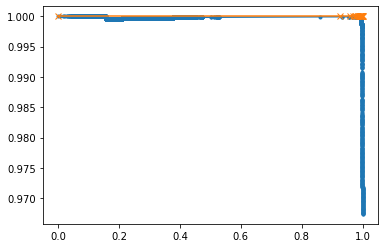

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(recall_lr, precision_lr, marker='.')
plt.plot(recall_rf, precision_rf, marker='x')